In [1]:
import torch

def poisson_noise(x: torch.Tensor, noise_factor=0.1, clamp=True, scale: float=1e5):
    """
    Add Poisson noise to the input tensor x.
    As we are adding it to raw sinogram (before further transformations down the road), it does not need to be log-poisson.
    """
    # Make sure x is non-negative, as Poisson noise is defined for non-negative values

    x_clean_min = x.min()
    x_clean_max = x.max()

    noise_factor = noise_factor * scale # For our sinograms which usually range in 1e-5, we need a big factor

    lam = x * noise_factor  # Lambda parameter for Poisson distribution
    noisy = torch.poisson(lam) / noise_factor  # Generate Poisson noise

    if clamp:
        # Clamp the noisy tensor to the range of the original tensor
        noisy = torch.clamp(noisy, min=x_clean_min, max=x_clean_max)  

    return noisy


def gaussian_noise(x: torch.Tensor, noise_factor=0.1, clamp=True, scale: float=1e-4):
    """
    Add Gaussian noise to the input tensor x.
    """
    # Make sure x is non-negative, as Gaussian noise can be negative
    x_clean_min = x.min()
    x_clean_max = x.max()

    noise = torch.randn_like(x) * noise_factor * scale # Generate Gaussian noise

    noisy = x + noise  # Add noise to the original tensor

    if clamp:
        # Clamp the noisy tensor to the range of the original tensor
        noisy = torch.clamp(noisy, min=x_clean_min, max=x_clean_max)

    return noisy


def sino_undersample(y: torch.Tensor, mask_proportion: float=0.2) -> torch.Tensor:
    """
    Undersample the input tensor x using the provided mask.
    The mask should be a binary tensor of the same shape as x.
    """
    # We are making a sinogram-like mask here, so vertically undersample the input tensor.

    # assert we have BCHW format
    if y.dim() != 4:
        raise ValueError(f"Input tensor y must be in BCHW format, got {y.dim()} dimensions instead.")

    mask: torch.Tensor = (torch.rand([y.shape[0], y.shape[1], 1, y.shape[3]]) > mask_proportion).expand(y.shape)  # Create a random boolean mask
    mask = mask.float().cuda()  # Convert mask to float for multiplication

    return y * mask  # Element-wise multiplication to apply the mask

A_ut shape: torch.Size([25600, 16384])
x shape: torch.Size([2, 128, 128])
y shape: torch.Size([25600])
y reshaped to: torch.Size([128, 200])
0.0786469210973844


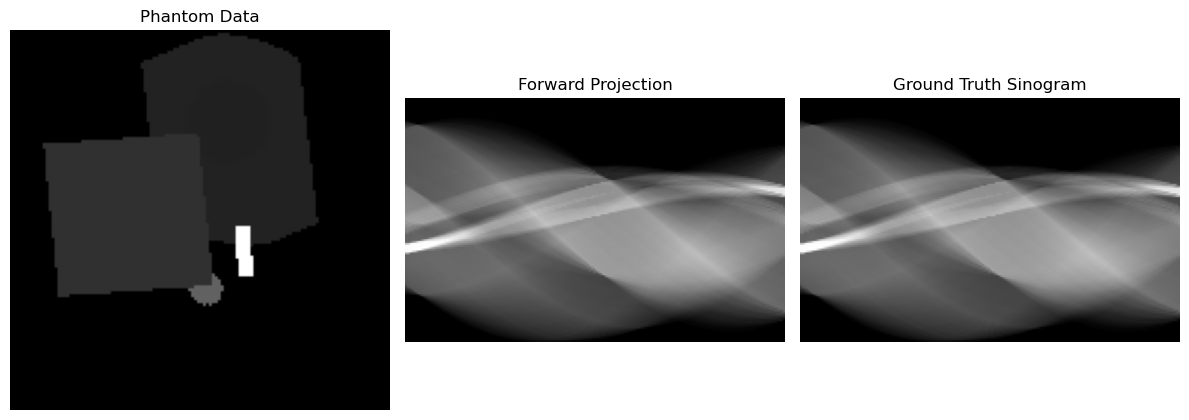

A_ut_pinv shape: torch.Size([16384, 25600])
y_noisy shape: torch.Size([128, 200])


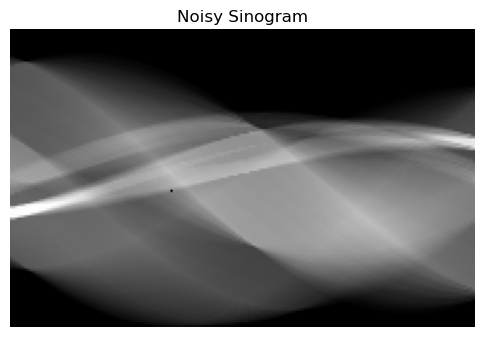

x_reconstructed shape: torch.Size([128, 128])


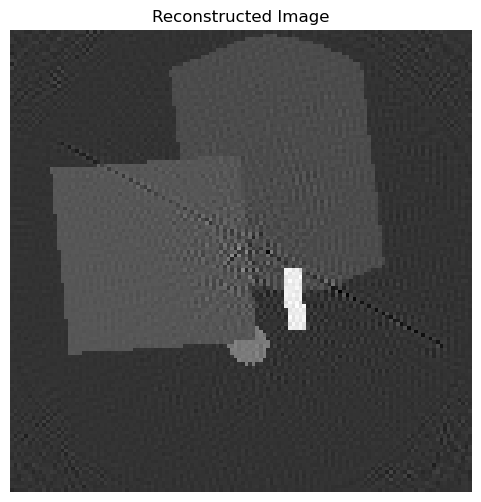

Min/Max of Phantom: 0.0/2.705002592622282e+24
Min/Max of Forward Projection: 0.0/0.0002705008373595774
Min/Max of Ground Truth Sinogram: 0.0/3.05711322710343e-05
Min/Max of Reconstructed Image: -7.414955569651825e+23/2.9817956992179176e+24


In [12]:
# Load the A_ut A_ub and A_tb matrices from the file and test them on forward projections of our phantom data

import numpy as np
import sys
import os
import matplotlib.pyplot as plt

import torch

data_folder: str = '../data_discretised/'

A_ut: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ut.npy')
#A_ub: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ub.npy')
#A_tb: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_tb.npy')

A_ut = A_ut.astype(np.float32)
#A_ub = A_ub.astype(np.float32)
#A_tb = A_tb.astype(np.float32)

A_ut = torch.tensor(A_ut).cuda()  # Move to GPU if available
#A_ub = torch.tensor(A_ub).cuda()  # Move to GPU if available
#A_tb = torch.tensor(A_tb).cuda()  # Move to GPU if available

print(f'A_ut shape: {A_ut.shape}')
#print(f'A_ub shape: {A_ub.shape}')
#print(f'A_tb shape: {A_tb.shape}')

# Load the phantom data
x: np.ndarray | torch.Tensor = np.load(os.path.join(data_folder, 'phan-96.npy'))
x = torch.tensor(x).cuda()  # Move to GPU if available

gt_sino: np.ndarray | torch.Tensor = np.load(os.path.join(data_folder, 'sino-96.npy'))
gt_sino = torch.tensor(gt_sino).cuda()  # Move to GPU if available

print(f'x shape: {x.shape}')

# Forward projection
y: torch.Tensor = A_ut @ x[0].ravel() #np.sum(x, axis=0).ravel()

print(f'y shape: {y.shape}')
y = y.reshape((128, -1))
print(f'y reshaped to: {y.shape}')

print(f'{torch.sum(y - torch.sum(gt_sino, axis=-1)).item()}')

# Plot the Phantom Data, Forward projection, and Ground Truth Sinogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(x[0].cpu().numpy(), cmap='gray')
plt.title('Phantom Data')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(y.cpu().numpy(), cmap='gray')
plt.title('Forward Projection')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.sum(gt_sino, axis=-1).cpu().numpy(), cmap='gray')
plt.title('Ground Truth Sinogram')
plt.axis('off')
plt.tight_layout()
plt.show()

A_ut_pinv: torch.Tensor = torch.tensor(np.load(f'{data_folder}A_ut_pinv.npy')).cuda()  # Load the pseudo-inverse of A_ut
print(f'A_ut_pinv shape: {A_ut_pinv.shape}')

# Let's degrade the y sinogram with some noise
y_noisy = y.clone()
y_noisy[69,69] = 0.0
#y_noisy: torch.Tensor = poisson_noise(y, noise_factor=0.1, clamp=True, scale=1e7)
#y_noisy = sino_undersample(y.unsqueeze(0).unsqueeze(0), mask_proportion=0.2).squeeze(0).squeeze(0)  # Undersample the noisy sinogram
print(f'y_noisy shape: {y_noisy.shape}')
# Plot the noisy sinogram
plt.figure(figsize=(6, 6))
plt.imshow(y_noisy.cpu().numpy(), cmap='gray')
plt.title('Noisy Sinogram')
plt.axis('off')
plt.show()


# Try applying the transpose of the matrix to the sinogram
x_reconstructed: torch.Tensor = A_ut_pinv @ y_noisy.ravel()
x_reconstructed = x_reconstructed.reshape((128, -1))
print(f'x_reconstructed shape: {x_reconstructed.shape}')
x_reconstructed = x_reconstructed.reshape(x[0].shape)
# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(x_reconstructed.cpu().numpy(), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

# Print min and max vaues of original phantom, forward projection, original sinogram, and reconstructed image
print(f'Min/Max of Phantom: {torch.min(x[0])}/{torch.max(x[0])}')
print(f'Min/Max of Forward Projection: {torch.min(y)}/{torch.max(y)}')
print(f'Min/Max of Ground Truth Sinogram: {torch.min(gt_sino)}/{torch.max(gt_sino)}')
print(f'Min/Max of Reconstructed Image: {torch.min(x_reconstructed)}/{torch.max(x_reconstructed)}')


A_ut_pinv shape: torch.Size([16384, 25600])
Residual (MAE): 5.2114276786445404e+22
PSNR: 14.619484901428223
SSIM: 0.2316659688949585


/home/samnub/anaconda3/envs/lircst-iterecon/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/home/samnub/anaconda3/envs/lircst-iterecon/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


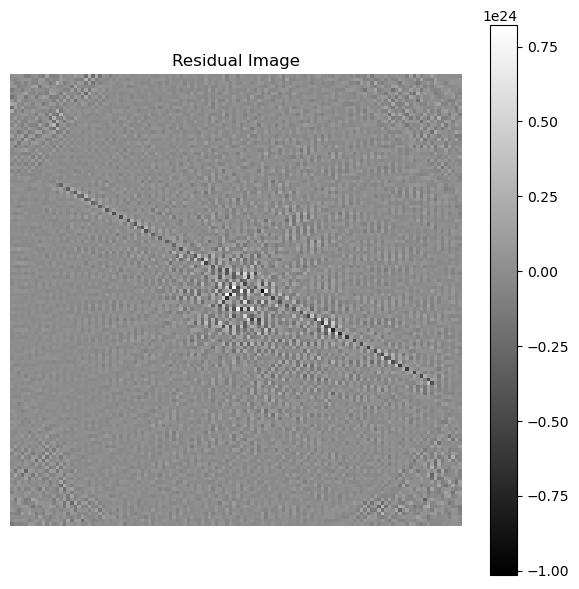

: 

In [ ]:
print(f'A_ut_pinv shape: {A_ut_pinv.shape}')

# Save the pinv matrix as numpy file
# np.save(f'{data_folder}A_ut_pinv.npy', A_ut_pinv.cpu().numpy())

# Let's compute the residual between x_reconstructed and the original phantom
residual: torch.Tensor = x_reconstructed - x[0]

print(f'Residual (MAE): {torch.mean(torch.abs(residual)).item()}')

# Let's also compute the PSNR and SSIM
import torchmetrics


x_reconstructed_scaled = x_reconstructed - torch.min(x_reconstructed)
x_reconstructed_scaled = x_reconstructed_scaled * (x_reconstructed_scaled.max() / x[0].max())

# Let's scale the images to [0, 1] for PSNR and SSIM calculation
x_reconstructed_scaled = (x_reconstructed_scaled - torch.min(x_reconstructed_scaled)) / (torch.max(x_reconstructed_scaled) - torch.min(x_reconstructed_scaled))
x_scaled = (x[0] - torch.min(x[0])) / (torch.max(x[0]) - torch.min(x[0]))

x_reconstructed_scaled = x_reconstructed_scaled.unsqueeze(0).unsqueeze(0)
x_scaled = x_scaled.unsqueeze(0).unsqueeze(0)

psnr = torchmetrics.functional.peak_signal_noise_ratio(x_reconstructed_scaled, x_scaled)
ssim = torchmetrics.functional.structural_similarity_index_measure(x_reconstructed_scaled, x_scaled)
print(f'PSNR: {psnr.item()}')
print(f'SSIM: {ssim.item()}')

# Plot the residual
plt.figure(figsize=(6, 6))
plt.imshow(residual.cpu().numpy(), cmap='gray')
plt.title('Residual Image')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()
